In [1]:
# !pip install vincenty

In [2]:
# import data analysis libraries
import pandas as pd
import numpy as np

# other
import os
import warnings

# visualisation libraries
from matplotlib import pyplot as plt
import seaborn as sns

from vincenty import vincenty
from glob import glob

# Notebook styling
%matplotlib inline
sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})
warnings.filterwarnings("ignore")

In [3]:
def add_feat(df_input):
    """
    This function takes in raw lat long time series from the microsoft geolife data.
    
    Preprocessing notes: skip the first six lines before doing pandas read csv ,
    expecting columns in ['lat','long', 'null', 'alt' ,'DateTime','Date','Time']
    
    Requres: pandas imported as pd
             from vincenty import vincenty
         
    Adds:
        speed
        acceleration
        jerk
        bearing rate
        distance travelled
    """
    
    df = df_input
    
    # add some initial shifts
    df['lat_shift'] = df.lat.shift(-1)
    df['long_shift'] = df.long.shift(-1)
    df['time_shift'] = df.DateTime.shift(-1)
    
    # add speed
    def speed(x):
        try:
            s = vincenty((x[-3],x[-2]),(x[0],x[1])) / ((x[-1]-x[4]) * 24) / 3.6
        except:
            s= np.nan
        return s
    
    df['speed'] = df.apply(speed,axis =1)
    df['speed_shift'] = df.speed_mps.shift(-1)
    
    # add acceleration
    def accel(x):
        try:
            a = (x[-1] - x[-2]) / ((x[9] - x[4]) *24*60*60)
        except:
            a = np.nan
        return a
    
    df['acceleration'] = df.apply(accel, axis =1)
    df['acceleration_shift'] = df.acceleration.shift(-1)
    
    # add jerk
    def jerk(x):
        try:
            j = (x[-1] - x[-2]) / ((x[9] - x[4]) *24*60*60)
        except:
            j = np.nan
        return a
    
    df['jerk'] = df.apply(accel, axis =1)
    df['jerk_shift'] = df.jerk.shift(-1)
    
    # add y for bearing calculator
    def y(x):
        try:
            yy = np.sin((x[8] - x[0]) * np.pi/180) *np.cos( x[7]* np.pi/180)
        except:
            yy= np.nan
        return yy
    
    df['y'] = df.apply(y, axis =1)
    
    # add x for bearing calculator 
    def x(x):
        try:
            xx = np.cos(x[0] * np.pi/180) *np.sin(x[7]* np.pi/180) - np.sin(x[0]* np.pi/180) * np.cos(x[7]* np.pi/180)*np.cos((x[8]-x[1])* np.pi/180)
        except:
            xx = np.nan
        return xx
    
    df['x'] = df.apply(x,axis =1)
    
    # calculate bearing
    def bearing(x):
        try:
            b = np.arctan2(x[-2],x[-1])*180/np.pi
        except:
            b = np.nan
        return b
    
    df['bearing'] = df.apply(bearing,axis=1)
    df['brearing_shift'] = df.bearing.shift(-1)
    
    # calculate bearing rate (rate of change of direction)
    def bearing_rate(x):
        try:
            br = abs(x[-1]-x[-2])
        except:
            br = np.nan
        return br
    
    df['bearing_rate'] = df.apply(bearing_rate,axis=1)
    
    # calculate distance travelled
    def distance(x):
        try:
            dist = vincenty((x[7],x[8]),(x[0],x[1])) * 1000
        except:
            dist= np.nan
        return dist
    
    df['distance'] = df.apply(distance,axis = 1)
    
    df.drop(df.tail(4).index,inplace=True)
    
    return df

def list_df_summary(input_df):
    '''
    Converts output from add_feat function into an observation for machine learning
    '''
    names = ['speed_10', 'speed_25', 'speed_50', 'speed_75', 'speed_90', 'speed_ave',
            'accel_10', 'accel_25', 'accel_50', 'accel_75', 'accel_90', 'accel_ave',
            'jerk_10', 'jerk_25', 'jerk_50', 'jerk_75', 'jerk_90', 'jerk_ave',
            'bearingRate_10', 'bearingRate_25', 'bearingRate_50', 'bearingRate_75',
            'bearingRate_90', 'bearingRate_ave', 'distance_traveled', 'time_traveled' ,
            'last_lat', 'last_long', 'start_lat', 'start_long']
    
    values = list()
    
    #speed
    values.append(input_df.quantile(.10)[8])
    values.append(input_df.quantile(.25)[8])
    values.append(input_df.quantile(.50)[8])
    values.append(input_df.quantile(.75)[8])
    values.append(input_df.quantile(.90)[8])
    values.append(input_df.mean()[8])
    
    #accel
    values.append(input_df.quantile(.10)[10])
    values.append(input_df.quantile(.25)[10])
    values.append(input_df.quantile(.50)[10])
    values.append(input_df.quantile(.75)[10])
    values.append(input_df.quantile(.90)[10])
    values.append(input_df.mean()[10])
    
    #jerk
    values.append(input_df.quantile(.10)[12])
    values.append(input_df.quantile(.25)[12])
    values.append(input_df.quantile(.50)[12])
    values.append(input_df.quantile(.75)[12])
    values.append(input_df.quantile(.90)[12])
    values.append(input_df.mean()[12])
    
    #bearing
    values.append(input_df.quantile(.10)[18])
    values.append(input_df.quantile(.25)[18])
    values.append(input_df.quantile(.50)[18])
    values.append(input_df.quantile(.75)[18])
    values.append(input_df.quantile(.90)[18])
    values.append(input_df.mean()[18])
    
    #distance travelled
    values.append(input_df.distance.sum())
    
    #time travelled
    values.append((input_df.iloc[-1,4] - input_df.iloc[0,4])*24*60)
    
    #lat long
    values.append(input_df.iloc[-1,0])
    values.append(input_df.iloc[-1,1])
    values.append(input_df.iloc[0,0])
    values.append(input_df.iloc[0,1])
    
    
    return pd.DataFrame([values],columns=names)

In [4]:
def find_stops(df, time_col = 'Time_elapsed_seconds', distance_col = 'distance', t_dwell_int = 421, dist_dwell_int = 100):
    """
    This function identifies the stops along the waypoints of a trip
    using time and distance rules
    
    ------------------------------------
    Parameters:
        df (pandas.DataFrame): DataFrame containing columns with
            time elapsed (time_col) and distance (distance_col)
            
        time_col (str): column with the amount of time that has elapsed in seconds (float)
        
        distance_col (str): column with distance covered in meters (float)
        
        t_dwell_int (float): the time interval used to determine stop over in seconds
        
        dist_dwell_int (float): max distance travlled during stop over during t_dwell_int in meters
        
        
    Returns: (pandas.DataFrame): Dataframe with column idetifying waypoints that are stops (bool)
    ------------------------------------
    Example1 :
    
    
    """
    # make copy of dataframe
    df = df.copy()
    
    # Create Column to identify stop overs
    df['bool_stop_over'] = np.nan

    # for each row [interval upper boundary]
    for upper_index in df.index:
        
        # instantiate change variables
        delta_index = 0
        time_interval = 0

        # get distance within time interval
        while time_interval < t_dwell_int:
            delta_index += 1
            time_interval += df[time_col].iloc[upper_index: upper_index + delta_index].sum()

        # sum the distance covered in the interval
        interval_distance = df.iloc[upper_index: upper_index + delta_index][distance_col].sum()

        # if the sum is greater than 100m, False
        if interval_distance >= dist_dwell_int:
            df.loc[upper_index: upper_index + delta_index, 'bool_stop_over'] = False

        # else, True
        else:
            df.loc[upper_index: upper_index + delta_index, 'bool_stop_over'] = True

    return df

In [5]:

def make_legs(df, stops_col = 'bool_stop_over'):
    """
    This function breaks up raw gps data from day into legs by assigning a leg identifier
    to each waypoints in between stops
    
    ------------------------------------
    Parameters:
        df (pandas.DataFrame): DataFrame containing column with stops 'bool_stop_over'
    
    Returns: (pandas.DataFrame): Dataframe
    ------------------------------------
    Example:
    
    
    """
    
    # make copy of dataframe
    df = df.copy()
    
    # Create Column to identify stop overs
    df['trip_leg_id'] = np.nan

    # instantiate variables
    leg_counter = 0
    previous_point = 'stop'

    # for each waypoint...
    for current_index in df.index:

        # if current row is 'stop'...
        if df.loc[current_index, stops_col] == True:

            # make current_point = 'stop'
            current_point = 'stop'

            # impute current point to dataframe value
            df.loc[current_index, 'trip_leg_id'] = current_point

        # ... else
        else:
            # make current_point = leg_counter
            current_point = f'leg_{leg_counter}'

            # if previous_point = 'stop'...
            if previous_point == 'stop':
                # add 1 to the leg counter
                leg_counter += 1
                current_point = f'leg_{leg_counter}'

                # impute current point to dataframe value
                df.loc[current_index, 'trip_leg_id'] = current_point

            # ... else
            else:
                # impute current point to dataframe value
                current_point = f'leg_{leg_counter}'
                df.loc[current_index, 'trip_leg_id'] = current_point

        # update previous point
        previous_point = current_point

    return df

In [6]:
def points_to_legs(df, leg_col = 'trip_leg_id', stop_id = 'stop'):
    """
    This function takes a dataframe of waypoints and returns a dataframe
    of trip legs.
    This function uses the outputs of 'make_legs' function
    
    ------------------------------------
    Parameters:
        df (pandas.DataFrame): DataFrame containing column with stops 'bool_stop_over'
        
        leg_col (str): name of column containing the identifiers of which leg
        
        stop_cat (str): the identifier used to for stop_overs
    
    Returns: (pandas.DataFrame): Dataframe
    ------------------------------------
    Example:
        >>> [import dataframe]
        >>> print(points_to_legs(df_dataset).shape)
        (23, 30)
    

    """
    
    # copy dataframe
    df = df.copy()
    
    # make list of legs
    trips_legs = [i for i in df[leg_col].unique()
                  if i is not 'stop']
    
    # instantiate list of trajectories
    list_legs = list()

    # for each leg
    for leg in trips_legs:

        # filter the trajectory 
        df_temp = df[
            df['trip_leg_id'] == leg
        ]

        # add trajectory features to list
        list_legs.append(list_df_summary(df_temp))

    # create dataset of trajectories
    df = pd.concat(list_legs)
    df.reset_index(drop=True, inplace=True)

    return df

# !!!!! NB!!!! Function Doc Tests

In [7]:
# df_points = df_dataset.loc[:1000, ['Time_elapsed_seconds', 'distance']]
# print(df_points.shape)
# print(df_points)

In [8]:
# df_points_stops = find_stops(df_points)
# print(df_points_stops.shape)
# print(f"bool_stop_over distribution:\n{df_points_stops['bool_stop_over'].value_counts()}")
# print('\n')
# print(df_points_stops['bool_stop_over'])

In [9]:
# make_legs(df_points_stops)

In [10]:
# df_points_legs = make_legs(df_points_stops)
# print(df_points_legs.shape)
# print(f"trip_leg_id distribution:\n{df_points_legs['trip_leg_id'].value_counts()}")
# print('\n')
# print(df_points_legs['trip_leg_id'])

In [11]:
# df_final_legs = points_to_legs(df_dataset)
# print(df_final_legs.shape)
# print(f"bool_stop_over distribution:\n{df_final_legs['bool_stop_over'].value_counts()}")
# print('\n')
# df_final_legs.head

In [12]:
# print(points_to_legs(df_dataset).shape)
# print(points_to_legs(df_dataset).columns)
# print(points_to_legs(df_dataset).info())

# !!!!! NB!!!! End of Function Doc Tests!!!!!

# Initial Data Assessment

## Import Data

In [13]:
import os
basepath = '../../../../resources/data/external/Geolife Trajectories 1.3/Data/'

print('Files')
for entry in os.listdir(basepath):
    if os.path.isfile(os.path.join(basepath, entry)):
        print(entry)
print('\n')
print('Folders')
for entry in os.listdir(basepath):
    if os.path.isdir(os.path.join(basepath, entry)):
        print(entry)

Files


Folders
107
126
132
037
000
131
153
023
075
101
119
141
080
008
021
129
165
138
109
054
111
031
052
016
172
018
110
130
144
099
027
173
137
117
155
064
180
136
167
134
113
135
091
065
140
125
036
108
055
090
032
077
147
079
089
073
128
049
152
146
098
071
169
030
143
174
133
043
103
011
056
118
083
044
181
092
025
150
057
006
020
122
022
156
121
120
009
048
067
001
179
003
014
177
115
051
045
162
095
035
068
171
088
024
097
149
038
028
074
112
096
007
076
170
034
050
104
041
061
164
161
158
176
084
100
019
017
005
039
151
094
085
040
010
046
145
139
059
053
042
175
102
004
106
159
013
058
069
163
178
142
063
166
114
078
086
157
148
029
087
116
026
072
060
012
123
002
015
105
082
033
066
127
047
168
081
093
062
124
070
160
154


In [14]:
# define col names
colnames = ['lat','long', 'null', 'alt' ,'DateTime','Date','Time']
file_loc = '107/Trajectory/20071002073329.plt'

df_dataset = pd.read_csv(basepath + file_loc, skiprows=6, names = colnames)
print(df_dataset.shape)
df_dataset.head()

(81, 7)


lat        long  null         alt      DateTime        Date      Time
0  39.975917  116.330117     0  216.535433  39357.314919  2007-10-02  07:33:29
1  39.973000  116.337767     0  216.535433  39357.315220  2007-10-02  07:33:55
2  39.973350  116.337300     0  187.007874  39357.315544  2007-10-02  07:34:23
3  39.973933  116.337700     0  177.165354  39357.316586  2007-10-02  07:35:53
4  39.974583  116.337850     0  239.501312  39357.317373  2007-10-02  07:37:01

In [15]:
df_dataset.tail()

lat        long  null         alt      DateTime        Date  \
76  39.975533  116.339450     0  144.356955  39357.386956  2007-10-02   
77  39.975733  116.338733     0   95.144357  39357.387512  2007-10-02   
78  39.974600  116.338383     0  213.254593  39357.388345  2007-10-02   
79  39.974033  116.338317     0  187.007874  39357.388796  2007-10-02   
80  39.973100  116.338217     0  347.769029  39357.389826  2007-10-02   

        Time  
76  09:17:13  
77  09:18:01  
78  09:19:13  
79  09:19:52  
80  09:21:21

# Data Preparation

In [16]:
df_dataset = add_feat(df_dataset)
print(df_dataset.shape)
df_dataset.head()

(77, 22)


lat        long  null         alt      DateTime        Date  \
0  39.975917  116.330117     0  216.535433  39357.314919  2007-10-02   
1  39.973000  116.337767     0  216.535433  39357.315220  2007-10-02   
2  39.973350  116.337300     0  187.007874  39357.315544  2007-10-02   
3  39.973933  116.337700     0  177.165354  39357.316586  2007-10-02   
4  39.974583  116.337850     0  239.501312  39357.317373  2007-10-02   

       Time  lat_shift  long_shift    time_shift  ...  acceleration  \
0  07:33:29  39.973000  116.337767  39357.315220  ...     -1.002442   
1  07:33:55  39.973350  116.337300  39357.315544  ...     -0.041953   
2  07:34:23  39.973933  116.337700  39357.316586  ...      0.002936   
3  07:35:53  39.974583  116.337850  39357.317373  ...     -0.007992   
4  07:37:01  39.974750  116.337317  39357.318437  ...      0.000737   

   acceleration_shift      jerk  jerk_shift         y         x    bearing  \
0           -0.041953  0.036942    0.001603  0.744740 -0.000051  90.003916   
1            0.002936  0.001603   -0.000121  0.744743  0.000006  89.999530   
2           -0.007992 -0.000121    0.000128  0.744737  0.000010  89.999217   
3            0.000737  0.000128    0.000018  0.744729  0.000011  89.999127   
4            0.002388  0.000018   -0.000030  0.744723  0.000003  89.999776   

   brearing_shift  bearing_rate  distance  
0       89.999530      0.004386   729.348  
1       89.999217      0.000313    55.674  
2       89.999127      0.000090    73.231  
3       89.999776      0.000649    73.301  
4       89.999799      0.000022    49.175  

[5 rows x 22 columns]

In [17]:
df_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 77 entries, 0 to 76
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   lat                 77 non-null     float64
 1   long                77 non-null     float64
 2   null                77 non-null     int64  
 3   alt                 77 non-null     float64
 4   DateTime            77 non-null     float64
 5   Date                77 non-null     object 
 6   Time                77 non-null     object 
 7   lat_shift           77 non-null     float64
 8   long_shift          77 non-null     float64
 9   time_shift          77 non-null     float64
 10  speed_mps           77 non-null     float64
 11  speed_shift         77 non-null     float64
 12  acceleration        77 non-null     float64
 13  acceleration_shift  77 non-null     float64
 14  jerk                77 non-null     float64
 15  jerk_shift          77 non-null     float64
 16  y         

In [18]:
df_dataset.columns

Index(['lat', 'long', 'null', 'alt', 'DateTime', 'Date', 'Time', 'lat_shift',
       'long_shift', 'time_shift', 'speed_mps', 'speed_shift', 'acceleration',
       'acceleration_shift', 'jerk', 'jerk_shift', 'y', 'x', 'bearing',
       'brearing_shift', 'bearing_rate', 'distance'],
      dtype='object')

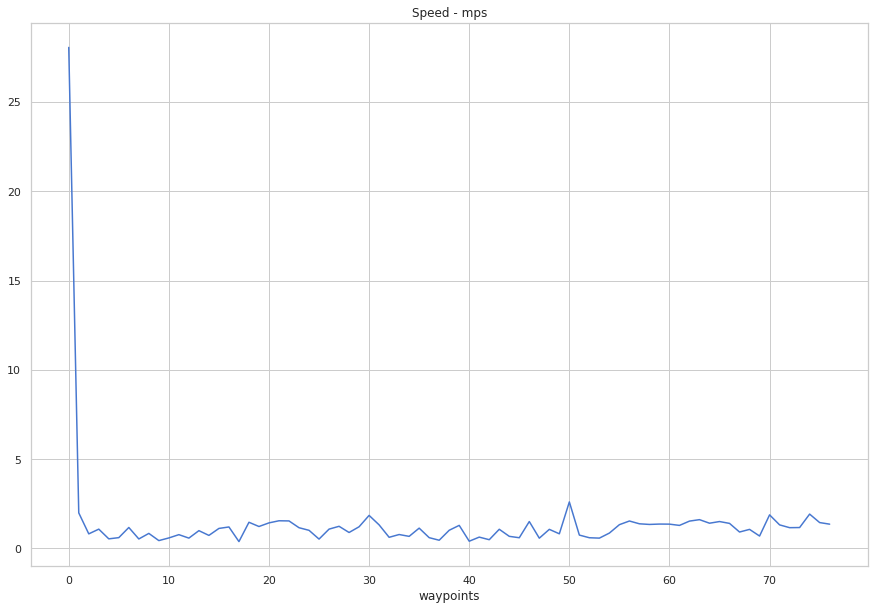

In [19]:
df_dataset['speed_mps'].plot(kind='line')
plt.title('Speed - mps')
plt.xlabel('waypoints')
plt.show()

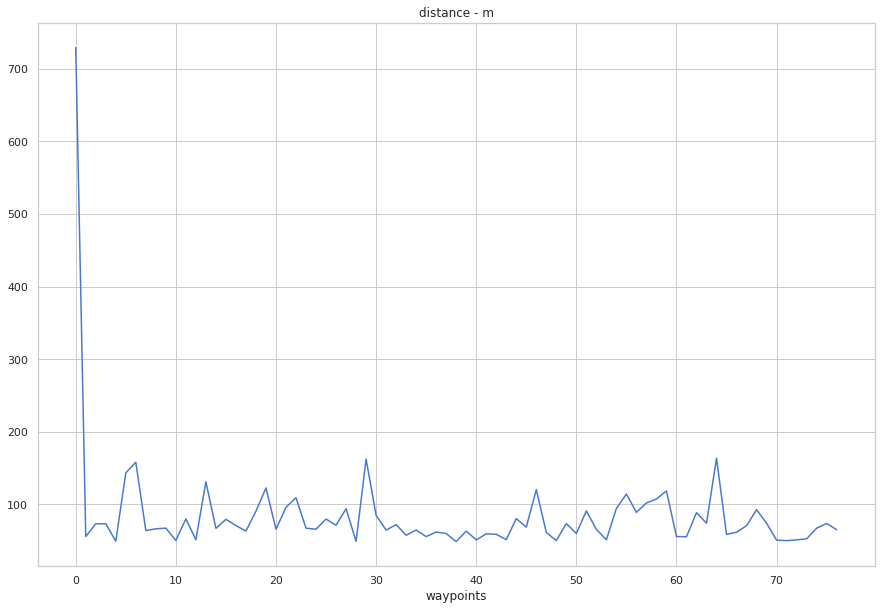

In [20]:
df_dataset['distance'].plot(kind='line')
plt.title('distance - m')
plt.xlabel('waypoints')
plt.show()

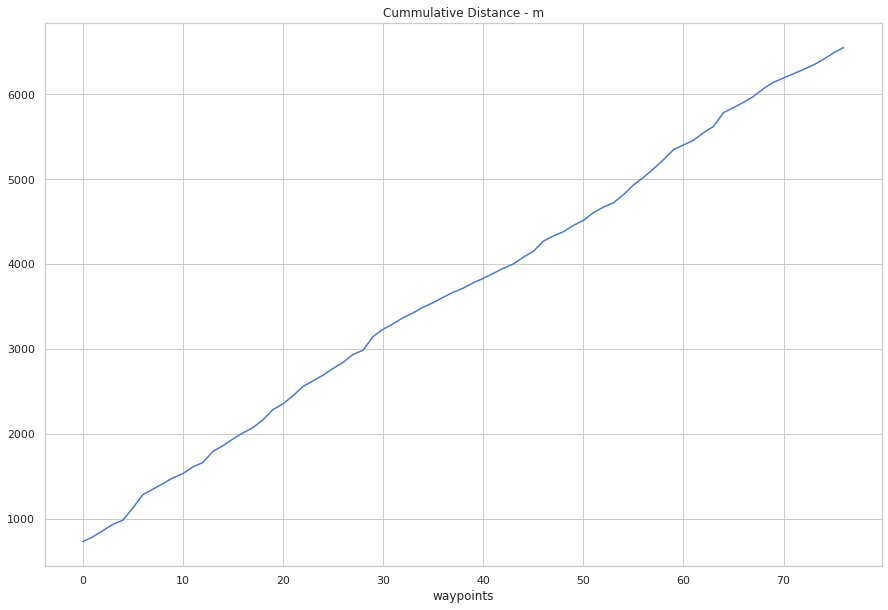

In [21]:
df_dataset['distance'].cumsum().plot(kind='line')
plt.title('Cummulative Distance - m')
plt.xlabel('waypoints')
plt.show()

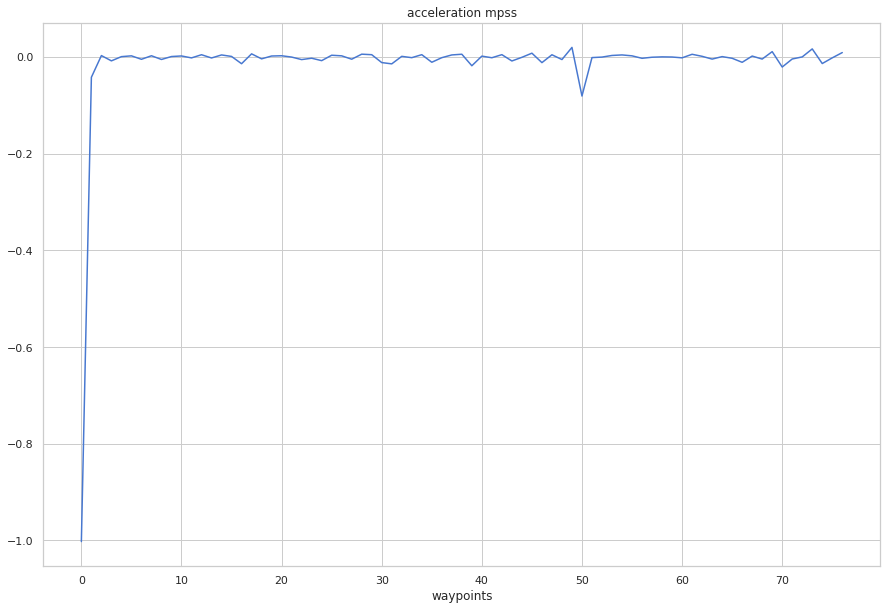

In [22]:
df_dataset['acceleration'].plot(kind='line')
plt.title('acceleration mpss')
plt.xlabel('waypoints')
plt.show()

## Separate Legs

In [23]:
df_dataset['cumm_distance'] = df_dataset['distance'].cumsum()
df_dataset['cumm_distance'].head()

0    729.348
1    785.022
2    858.253
3    931.554
4    980.729
Name: cumm_distance, dtype: float64

In [24]:
# convert time to datetime
df_dataset['Time'] = pd.to_datetime(df_dataset['Time'],format= '%H:%M:%S')
df_dataset.sort_values('Time', inplace=True)
df_dataset['Time'].head()

0   1900-01-01 07:33:29
1   1900-01-01 07:33:55
2   1900-01-01 07:34:23
3   1900-01-01 07:35:53
4   1900-01-01 07:37:01
Name: Time, dtype: datetime64[ns]

In [25]:
# plot 
df_dataset['Time_elapsed_seconds'] = df_dataset['Time'].diff().dt.seconds
df_dataset['Time_elapsed_seconds']

0      NaN
1     26.0
2     28.0
3     90.0
4     68.0
      ... 
72    38.0
73    44.0
74    45.0
75    35.0
76    51.0
Name: Time_elapsed_seconds, Length: 77, dtype: float64

In [26]:
df_dataset = find_stops(df_dataset)
print(df_dataset.shape)
print(f"bool_stop_over distribution:\n{df_dataset['bool_stop_over'].value_counts()}")
print('\n')
df_dataset['bool_stop_over'].head()

(77, 25)
bool_stop_over distribution:
False    76
True      1
Name: bool_stop_over, dtype: int64




0    False
1    False
2    False
3    False
4    False
Name: bool_stop_over, dtype: object

In [27]:
df_dataset = make_legs(df_dataset)
print(df_dataset.shape)
print(f"trip_leg_id distribution:\n{df_dataset['trip_leg_id'].value_counts()}")
print('\n')
print(df_dataset['trip_leg_id'])

(77, 26)
trip_leg_id distribution:
leg_1    76
stop      1
Name: trip_leg_id, dtype: int64


0     leg_1
1     leg_1
2     leg_1
3     leg_1
4     leg_1
      ...  
72    leg_1
73    leg_1
74    leg_1
75    leg_1
76     stop
Name: trip_leg_id, Length: 77, dtype: object


## Engineer Features

In [28]:
df_final_legs = points_to_legs(df_dataset)
print(df_final_legs.shape)
df_final_legs.head()

(1, 30)


speed_10  speed_25  speed_50  speed_75  speed_90  speed_ave  accel_10  \
0  0.553307  0.675035  1.078417   1.36596  1.542457   1.424202 -0.012594   

   accel_25  accel_50  accel_75  ...  bearingRate_50  bearingRate_75  \
0 -0.004614 -0.000168  0.002663  ...        0.000291        0.000677   

   bearingRate_90  bearingRate_ave  distance_traveled  time_traveled  \
0        0.001018         0.000471           6486.775     102.883333   

    last_lat  last_long  start_lat  start_long  
0  39.975283  116.34025  39.975917  116.330117  

[1 rows x 30 columns]

In [29]:
from sklearn.preprocessing import StandardScaler

# ## Remove longer trips
# df_local_all_feat = df_legs[(df_legs.time_traveled < 300)
#                                & (df_legs.distance_traveled < 100)
#                                & (df_legs.speed_90 < 75)]

## Select Features with unique distributions
select_cols = ['speed_90','speed_ave','accel_75','speed_50','accel_ave','distance_traveled','time_traveled']
df_local = df_final_legs[select_cols]

## Scale Data for KMeans
X = StandardScaler()
X = X.fit_transform(df_local)

In [30]:
X.shape

(1, 7)

In [31]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import Counter

#################################
### PERFORM KMeans CLUSTERING ###
#################################

Sum_of_squared_distances = []
scores = []
cluster_count = []

K= range(2,15,1)
for i in K:
    km = KMeans(n_clusters=i)
    km.fit(X)
    pred =km.predict(X)
    Sum_of_squared_distances.append(km.inertia_)
    scores.append(silhouette_score(X, pred))
    cluster_count.append(i)
    print(Counter(pred))
    print(str(silhouette_score(X, pred)) + ' clusters:' +str(i))
    print('------')
    
########################################
### Elbow plot with silhouette score ###
########################################sns.set_context('talk')
sns.lineplot(cluster_count,scores)
plt.xlabel('Cluster Count')
plt.ylabel('Silhouette Score')
plt.title('Elbow Method For Optimal Cluster Count')
plt.show()

ValueError: n_samples=1 should be >= n_clusters=2

In [ ]:
from sklearn.cluster import KMeans

df_final_legs['cluster'] = KMeans(n_clusters=7).fit_predict(X)
print(df_final_legs.shape)
df_final_legs.head()

In [ ]:
import os
directory = "/home/modisa/Documents/work/GoMetro/Urban Mobility Observatory/data/Raw/Geolife Trajectories 1.3/Data/"

# list all the trajectory files
list_files = [os.path.join(root, file)
              for root, subdirectories, files in os.walk(directory)
              for file in files
              if file.endswith(".plt")]

print(f'list size: {len(list_files)}')
list_files